MLB Team Projections generated and saved for 2026–2028.


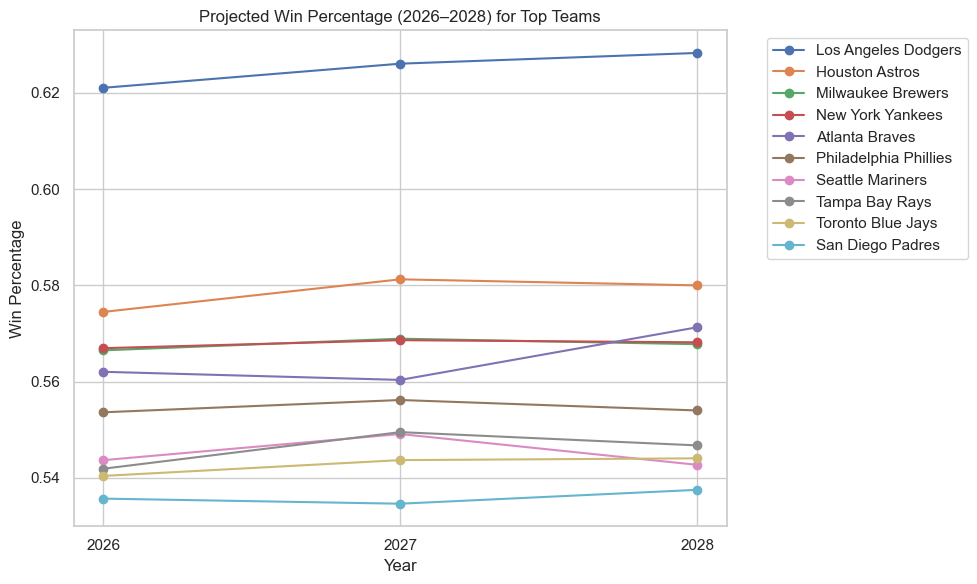

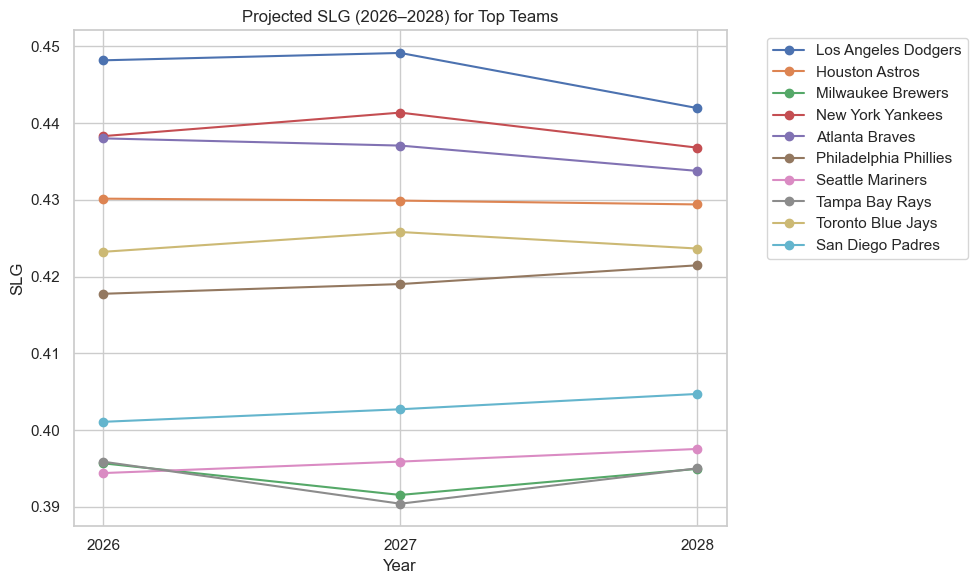

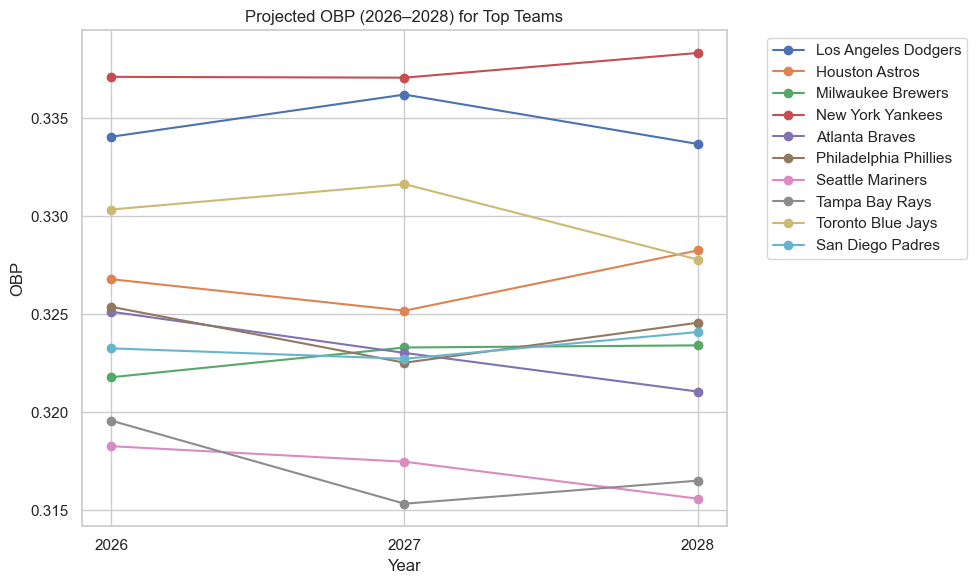

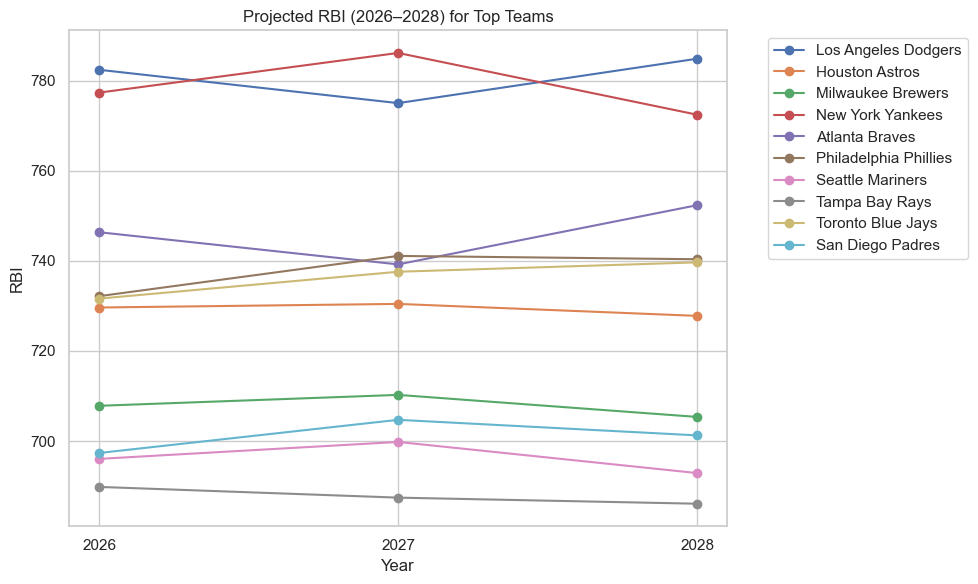

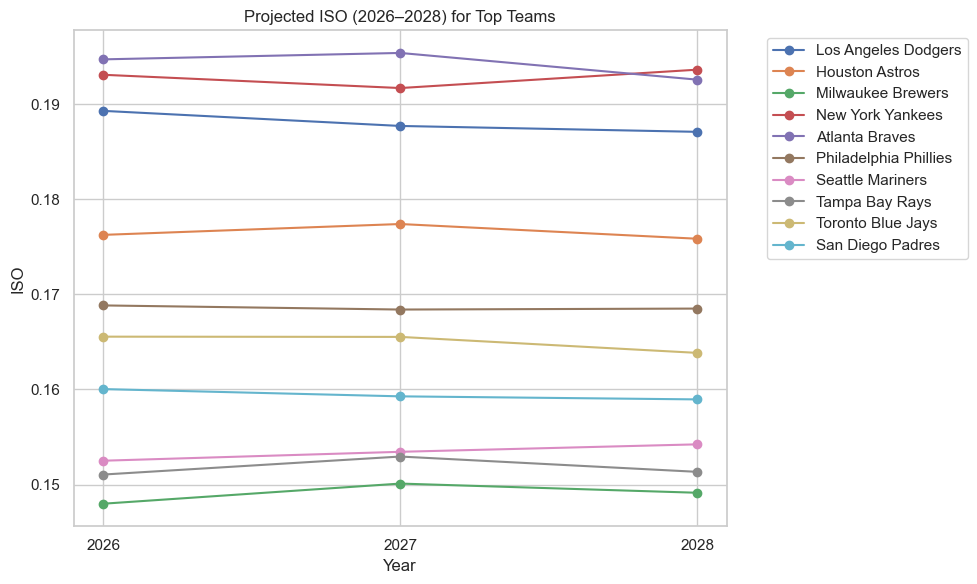

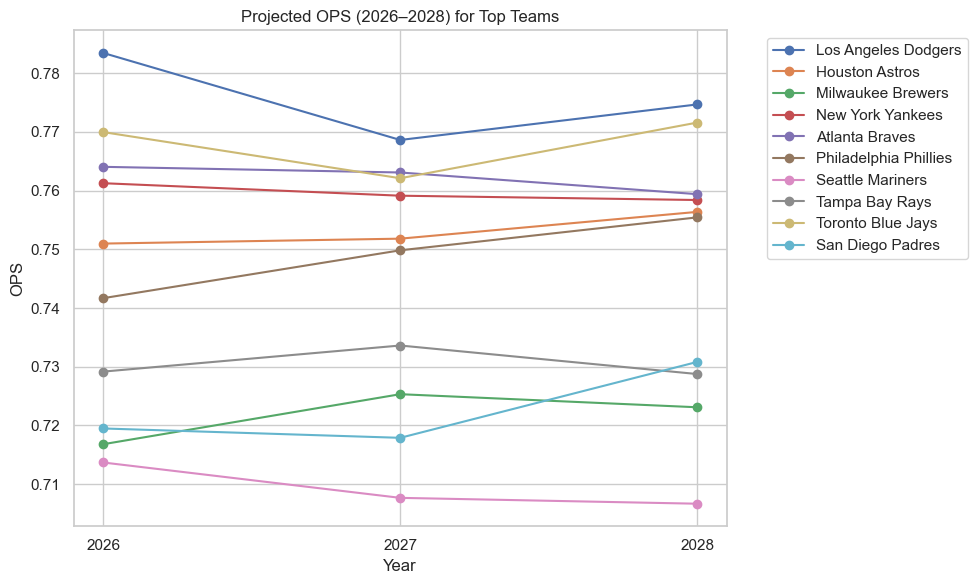

In [9]:
# ==============================
# MLB Team Projection 2026–2028
# ==============================

import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# ---- CONFIG ----
FILE_PATH = "../data/MLB team stats 2021-2025.csv"
OUTPUT_FOLDER = "../output"
YEARS_PROJ = [2026, 2027, 2028]

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ---- READ DATA ----
df = pd.read_csv(FILE_PATH)

# ---- KPI CORRELATIONS ----
kpi_predictors = {
    'Win%': ['Avg. OBP (2021-2025)', 'Avg. RBI (2021-2025)'],
    'Avg. SLG (2021-2025)': ['Avg. RBI (2021-2025)', 'Avg. ISO (2021-2025)'],
    'Avg. OBP (2021-2025)': ['Avg. RBI (2021-2025)', 'Avg. OPS (2021-2025)', 'Avg. SLG (2021-2025)'],
    'Avg. RBI (2021-2025)': ['Avg. SLG (2021-2025)', 'Avg. OBP (2021-2025)', 'Avg. OPS (2021-2025)', 'Avg. ISO (2021-2025)'],
    'Avg. ISO (2021-2025)': ['Avg. SLG (2021-2025)', 'Avg. RBI (2021-2025)', 'Avg. OPS (2021-2025)'],
    'Avg. OPS (2021-2025)': ['Avg. OBP (2021-2025)', 'Avg. RBI (2021-2025)', 'Avg. ISO (2021-2025)']
}

display_names = {
    'Win%': 'Win Percentage',
    'Avg. SLG (2021-2025)': 'SLG',
    'Avg. OBP (2021-2025)': 'OBP',
    'Avg. RBI (2021-2025)': 'RBI',
    'Avg. ISO (2021-2025)': 'ISO',
    'Avg. OPS (2021-2025)': 'OPS'
}

# ---- PROJECTION FUNCTION WITH NATURAL VARIATION ----
def project_kpi(df, kpi, predictors):
    proj_dict = {}
    for team in df['Team']:
        y_hist = df.loc[df['Team'] == team, kpi].values
        if len(y_hist) == 0:
            y_hist = [0]*5
        
        X_years = np.arange(len(y_hist)).reshape(-1, 1)
        model = LinearRegression()
        model.fit(X_years, y_hist)
        
        # Base projection
        proj_values = model.predict(np.arange(len(y_hist), len(y_hist)+len(YEARS_PROJ)).reshape(-1, 1))
        
        # Generate a small per-year random variation (up/down)
        variation = np.random.uniform(-0.01, 0.01, len(YEARS_PROJ))
        proj_values = proj_values * (1 + variation)
        
        proj_dict[team] = proj_values
    
    proj_df = pd.DataFrame(proj_dict, index=YEARS_PROJ)
    return proj_df

# ---- Generate projections for each KPI ----
proj_dfs = {}
for kpi, predictors in kpi_predictors.items():
    proj_dfs[kpi] = project_kpi(df, kpi, predictors)

# ---- Save projection CSVs ----
for kpi, proj in proj_dfs.items():
    proj.to_csv(os.path.join(OUTPUT_FOLDER, f"MLB_team_projection_{display_names[kpi]}_2026_2028.csv"))

print("MLB Team Projections generated and saved for 2026–2028.")

# ---- USER-FRIENDLY PLOTS ----
sns.set(style="whitegrid")
top_teams = df.sort_values('Win%', ascending=False)['Team'].head(10).tolist()

for kpi, proj in proj_dfs.items():
    plt.figure(figsize=(10,6))
    for team in top_teams:
        plt.plot(proj.index, proj[team], marker='o', label=team)
    plt.title(f"Projected {display_names[kpi]} (2026–2028) for Top Teams")
    plt.xlabel("Year")
    plt.ylabel(display_names[kpi])
    plt.xticks(proj.index)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save image
    img_filename = os.path.join(OUTPUT_FOLDER, f"MLB_team_projection_{display_names[kpi]}_2026_2028.png")
    plt.savefig(img_filename, dpi=300)
    
    plt.show()